In [37]:
import json
import math
import os
import cv2
import keras.engine.functional
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import *
from keras.applications.resnet import *
# import keras
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline

# Loading & Preprocessing

In [25]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            # print("img =",img)
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('../data/train/train/nevus',224))
malign_train = np.array(Dataset_loader('../data/train/train/melanoma',224))
benign_test = np.array(Dataset_loader('../data/test/test/nevus',224))
malign_test = np.array(Dataset_loader('../data/test/test/melanoma',224))

100%|████████████████████████████████████████████████████████████████████████████████| 117/117 [00:20<00:00,  5.72it/s]


# Create Label

In [38]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test)) 

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [39]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

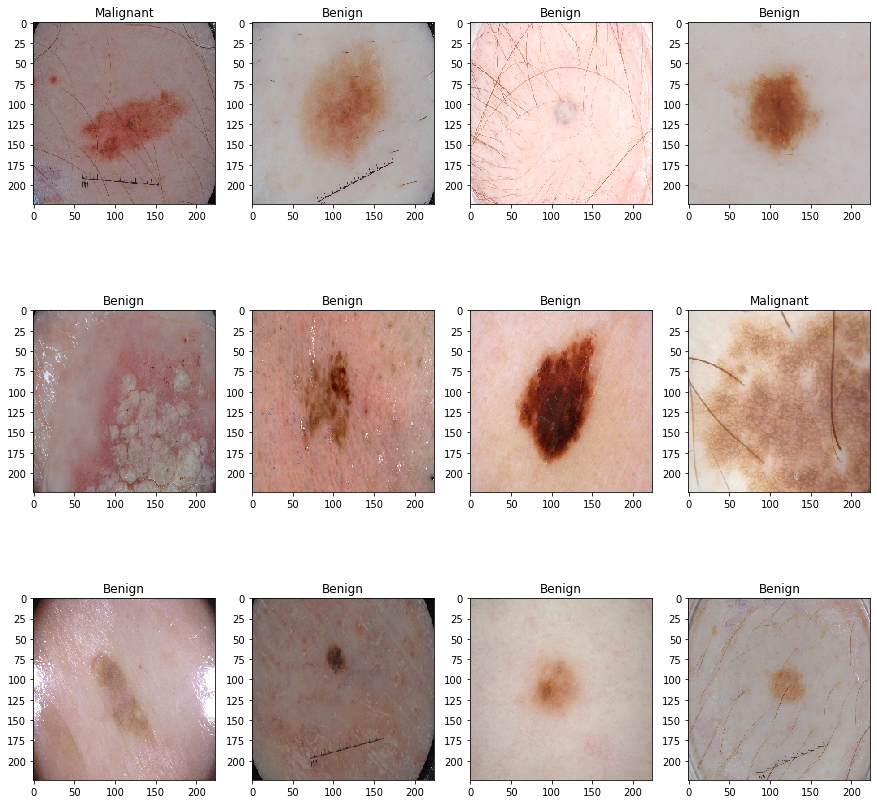

In [40]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [41]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
        zoom_range=2, 
        rotation_range = 90,
        horizontal_flip=True, 
        vertical_flip=True, 
    )

# Model: ResNet50


In [42]:
def build_model(backbone, lr=5e-4):
    model = Sequential()
    model.add(backbone)
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [43]:
K.clear_session()
gc.collect()

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


In [44]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [45]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/50
25/25 [==============================] - 286s 11s/step - loss: 0.8706 - accuracy: 0.5341 - val_loss: 0.5293 - val_accuracy: 0.7775

Epoch 00001: val_accuracy improved from -inf to 0.77750, saving model to weights.best.hdf5


c:\users\alexa\appdata\local\programs\python\python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
25/25 [==============================] - 257s 10s/step - loss: 0.7895 - accuracy: 0.5922 - val_loss: 0.5863 - val_accuracy: 0.7350

Epoch 00002: val_accuracy did not improve from 0.77750
Epoch 3/50
25/25 [==============================] - 254s 10s/step - loss: 0.7443 - accuracy: 0.6216 - val_loss: 0.5916 - val_accuracy: 0.7875

Epoch 00003: val_accuracy improved from 0.77750 to 0.78750, saving model to weights.best.hdf5
Epoch 4/50
25/25 [==============================] - 252s 10s/step - loss: 0.7241 - accuracy: 0.6333 - val_loss: 0.5804 - val_accuracy: 0.7575

Epoch 00004: val_accuracy did not improve from 0.78750
Epoch 5/50
25/25 [==============================] - 252s 10s/step - loss: 0.6893 - accuracy: 0.6819 - val_loss: 0.5331 - val_accuracy: 0.7850

Epoch 00005: val_accuracy did not improve from 0.78750
Epoch 6/50
25/25 [==============================] - 251s 10s/step - loss: 0.6691 - accuracy: 0.7067 - val_loss: 0.5180 - val_accuracy: 0.7900

Epoch 00006: val_accuracy 

25/25 [==============================] - 252s 10s/step - loss: 0.3319 - accuracy: 0.8785 - val_loss: 0.4390 - val_accuracy: 0.8275

Epoch 00040: val_accuracy did not improve from 0.85500
Epoch 41/50
25/25 [==============================] - 253s 10s/step - loss: 0.3222 - accuracy: 0.8805 - val_loss: 0.4369 - val_accuracy: 0.8300

Epoch 00041: val_accuracy did not improve from 0.85500
Epoch 42/50
25/25 [==============================] - 252s 10s/step - loss: 0.3067 - accuracy: 0.8879 - val_loss: 0.4390 - val_accuracy: 0.8325

Epoch 00042: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.

Epoch 00042: val_accuracy did not improve from 0.85500
Epoch 43/50
25/25 [==============================] - 251s 10s/step - loss: 0.3224 - accuracy: 0.8821 - val_loss: 0.4371 - val_accuracy: 0.8325

Epoch 00043: val_accuracy did not improve from 0.85500
Epoch 44/50
25/25 [==============================] - 251s 10s/step - loss: 0.3321 - accuracy: 0.8810 - val_loss: 0.4326 - val_accuracy:

In [47]:
model.save('saved.model')

c:\users\alexa\appdata\local\programs\python\python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved.model\assets


In [48]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

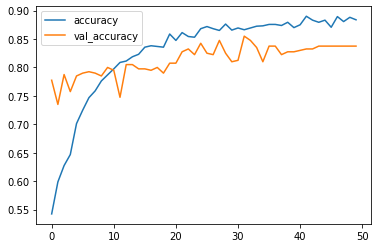

In [49]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

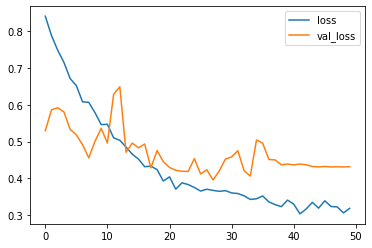

In [50]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [51]:
model.load_weights("weights.best.hdf5")

In [52]:
Y_val_pred = model.predict(x_val)

In [53]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.855

In [54]:
Y_pred = model.predict(X_test)

In [55]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]c:\users\alexa\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:37<00:00, 21.73s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[461  22]
 [ 75  42]]


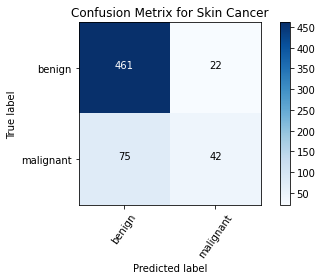

In [56]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[460  23]
 [ 76  41]]


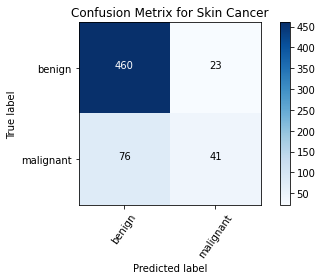

In [57]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

### Classification Report

In [58]:
from sklearn.metrics import classification_report
a = classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

In [59]:
print(a)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       483
           1       0.64      0.35      0.45       117

    accuracy                           0.83       600
   macro avg       0.75      0.65      0.68       600
weighted avg       0.82      0.83      0.82       600



### ROC and AUC

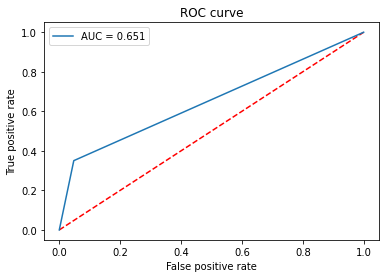

In [60]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()
